# Databyte Task 2: Image Classification of Marvel Characters 
* Using the "marvel-heroes" dataset on Kaggle and a pretrained Tensorflow/Keras CNN

# Importing Libraries

In [33]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path #for working with the data

#for visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#for making the train-test split
from sklearn.model_selection import train_test_split

import tensorflow as tf #building the model

from sklearn.metrics import confusion_matrix, classification_report #analysing

In [22]:
image_dir = Path('../input/marvel-heroes/marvel')

# Creating a Dataframe
With two columns, file path and labels

In [23]:
filepaths = list(image_dir.glob(r'**/*.jpg')) #storing jpg file paths

#The hero name is above the image name, hence we split twice to get the labels
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths)) 

#converting filepaths and labels to series
filepaths = pd.Series(filepaths, name='Filepath').astype(str) #path object to string
labels = pd.Series(labels, name='Label')

#dataframe formed
image_df = pd.concat([filepaths, labels], axis=1) #axis=1 means side by side

image_df['Label'].value_counts() #since 700-800 images per hero will take long to compute, we take samples

doctor strange     812
spider-man         766
captain america    762
thanos             756
hulk               754
black widow        750
ironman            748
loki               722
Name: Label, dtype: int64

In [24]:
samples = []
for category in image_df['Label'].unique(): #iterating through all the unique values
    category_slice = image_df.query("Label == @category") #referring to the hero to be sampled
    samples.append(category_slice.sample(200, random_state=1)) #taking 200 samples
#concat into a single df and shuffling them by sampling 100% of the data
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

image_df['Label'].value_counts()

loki               200
ironman            200
black widow        200
doctor strange     200
spider-man         200
captain america    200
hulk               200
thanos             200
Name: Label, dtype: int64

In [25]:
image_df

,Filepath,Label
0,../input/marvel-heroes/marvel/marvel/train/lok...,loki
1,../input/marvel-heroes/marvel/marvel/train/iro...,ironman
2,../input/marvel-heroes/marvel/train/black wido...,black widow
3,../input/marvel-heroes/marvel/marvel/train/iro...,ironman
4,../input/marvel-heroes/marvel/train/doctor str...,doctor strange
...,...,...
1595,../input/marvel-heroes/marvel/train/thanos/pic...,thanos
1596,../input/marvel-heroes/marvel/marvel/train/hul...,hulk
1597,../input/marvel-heroes/marvel/train/spider-man...,spider-man
1598,../input/marvel-heroes/marvel/marvel/train/cap...,captain america


In [26]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

# Loading the Image Data

In [27]:
#Loading in a batch of images at a time, training them and recycling the memory for a new batch
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    #transfer learning(mobilenet) Feature extraction layers already trained. We drop the classification part and do it oursleves
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [28]:
#flow images from the dfs into generators
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 896 validated image filenames belonging to 8 classes.
Found 224 validated image filenames belonging to 8 classes.
Found 480 validated image filenames belonging to 8 classes.


# Training

In [30]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3), #default shape
    include_top=False, #final layers are false since we use our own top
    weights='imagenet',
    pooling='avg' #3D gets pooled down to 1D
)

pretrained_model.trainable = False #trainable parameters are 0 since we're using the same weights as were learned by the original training of the model

In [31]:
#feature extraction part
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(8, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

2022-11-20 09:59:28.959371: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
28/28 [==============================] - 32s 1s/step - loss: 1.8271 - accuracy: 0.3415 - val_loss: 1.4173 - val_accuracy: 0.5223
Epoch 2/100
28/28 [==============================] - 23s 805ms/step - loss: 1.0586 - accuracy: 0.6730 - val_loss: 1.2376 - val_accuracy: 0.5982
Epoch 3/100
28/28 [==============================] - 23s 804ms/step - loss: 0.7049 - accuracy: 0.7868 - val_loss: 1.2088 - val_accuracy: 0.6027
Epoch 4/100
28/28 [==============================] - 23s 799ms/step - loss: 0.5057 - accuracy: 0.8527 - val_loss: 1.2708 - val_accuracy: 0.5938
Epoch 5/100
28/28 [==============================] - 22s 797ms/step - loss: 0.3359 - accuracy: 0.9141 - val_loss: 1.2084 - val_accuracy: 0.6384
Epoch 6/100
28/28 [==============================] - 23s 806ms/step - loss: 0.2108 - accuracy: 0.9531 - val_loss: 1.3738 - val_accuracy: 0.5982
Epoch 7/100
28/28 [==============================] - 22s 781ms/step - loss: 0.1373 - accuracy: 0.9766 - val_loss: 1.3769 - val_accuracy: 0.

# Results

Test Accuracy: 62.08%


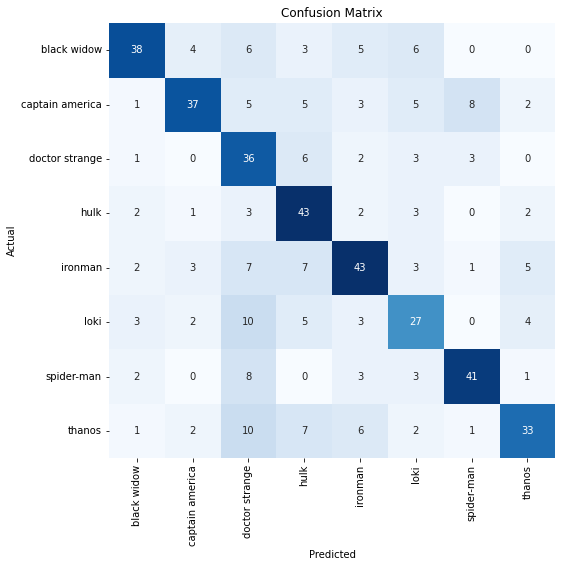

Classification Report:
----------------------
                  precision    recall  f1-score   support

    black widow       0.76      0.61      0.68        62
captain america       0.76      0.56      0.64        66
 doctor strange       0.42      0.71      0.53        51
           hulk       0.57      0.77      0.65        56
        ironman       0.64      0.61      0.62        71
           loki       0.52      0.50      0.51        54
     spider-man       0.76      0.71      0.73        58
         thanos       0.70      0.53      0.61        62

       accuracy                           0.62       480
      macro avg       0.64      0.62      0.62       480
   weighted avg       0.65      0.62      0.62       480



In [32]:
results = model.evaluate(test_images, verbose=0)
predictions = np.argmax(model.predict(test_images), axis=1)

class_names = list(test_images.class_indices.keys())

cm = confusion_matrix(test_images.labels, predictions, labels=np.arange(8))
clr = classification_report(test_images.labels, predictions, labels=np.arange(8), target_names=class_names)

print("Test Accuracy: {:.2f}%".format(results[1] * 100))

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(8) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n----------------------\n", clr)